<a href="https://colab.research.google.com/github/mymooss/checkParkingSpace/blob/main/Check_ParkingSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


In [3]:
!pip install keras==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os, glob
import scipy
import numpy as np

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))



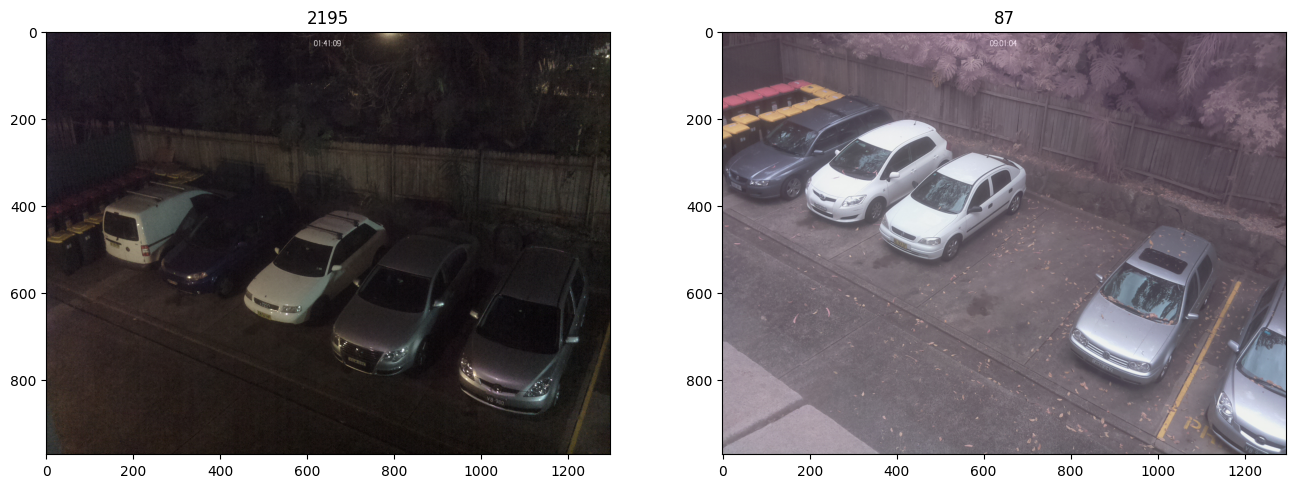

In [4]:
full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9,1.1],
    validation_split=0.1, #10퍼센트의 데이터를 검증 데이터로 사용
    preprocessing_function = preprocess_input #keras.application.mobileV2에 있음
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)


train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),#리사이징
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 2055 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


In [7]:
base_model = MobileNetV2(input_shape=(224,224,3), weights = 'imagenet',
                         include_top= False) #이미 학습된 모델을 transfer leaning 전이학습

x = base_model.output
x = GlobalAveragePooling2D()(x)# 1차원으로 데이터를 펴줌
output = Dense(2, activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [8]:
for layer in model.layers:
    layer.trainable = True

In [9]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('parking_model.h5',monitor='val_acc', save_best_only = True, verbose=1)
    ]
)

<ipython-input-9-a8f1b4ce9613>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.0499 - acc: 0.9796 
Epoch 1: val_acc improved from -inf to 0.73128, saving model to parking_model.h5
65/65 [==============================] - 1516s 23s/step - loss: 0.0499 - acc: 0.9796 - val_loss: 1.0042 - val_acc: 0.7313
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 1.2745e-04 - acc: 1.0000
Epoch 2: val_acc did not improve from 0.73128
65/65 [==============================] - 116s 2s/step - loss: 1.2745e-04 - acc: 1.0000 - val_loss: 3.3172 - val_acc: 0.1850
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.0038 - acc: 0.9990
Epoch 3: val_acc improved from 0.73128 to 0.95595, saving model to parking_model.h5
65/65 [==============================] - 118s 2s/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.1413 - val_acc: 0.9559
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.0113 - acc: 0.9961
Epoch 4: val_acc improved from 0.95595 to 0.96916, saving mode

In [10]:
model = load_model('parking_model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2)
   
new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

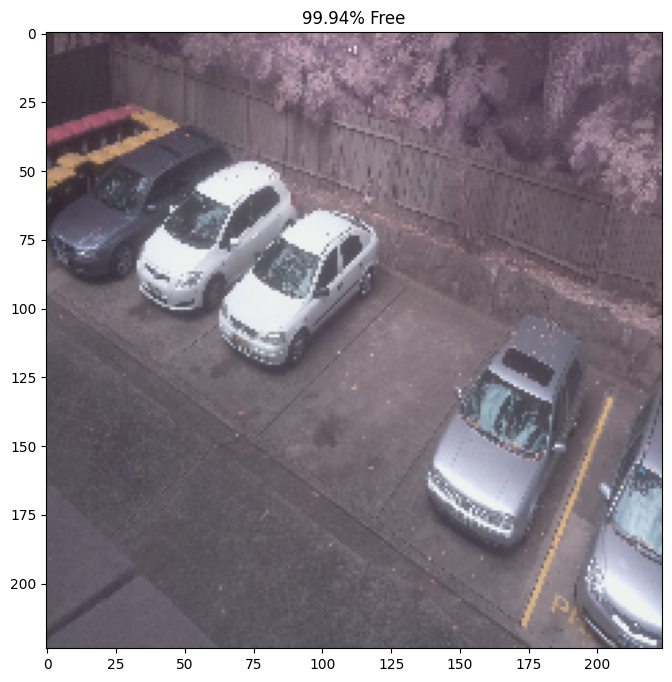

In [20]:
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_1006144058.jpg'),
                                 target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

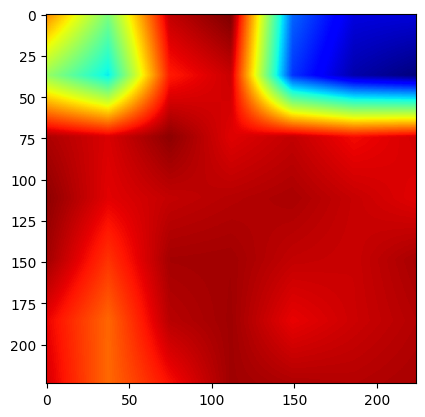

In [21]:
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

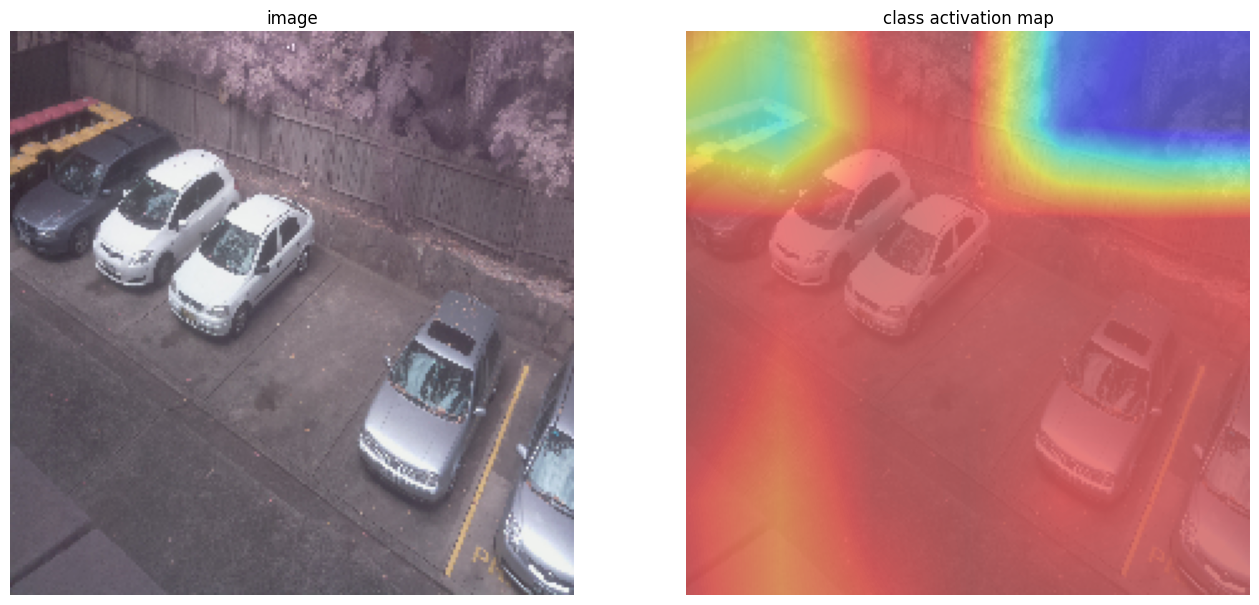

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()